# Probabilistic Machine Learning
#### Machine Learning in Science, University of Tübingen, Summer Semester 2024
## Exercise 07


---

In the lecture you learned about different methods that allow sampling from complex distributions. In this programming exercise, you will explore **importance sampling in order to refine laplace approximations** and implement a **Gibbs-sampler for an Ising model**.


## Outline
1) Refining Laplace approximations with importance sampling.

2) Gibbs-sampling for Ising model.

# Refining Laplace approximations with importance sampling

In [1]:
import torch
import matplotlib.pyplot as plt
from torch.autograd.functional import hessian
from torch.distributions import Normal, Uniform, Bernoulli
from copy import deepcopy

In the first part of the exercise, we will refine a laplace approximation with importance sampling. Our goal will be to estimate the posterior mean $\mathbb{E}[p(y|x)]$ with Monte-Carlo sampling. We will show that the laplace approximation can fail to estimate this mean accurately, and that importance sampling can improve the estimate. First, we define a simple model $p(y|x)$ and a prior $p(x)$. The likelihood is $p(y | x) = \mathcal{N}(\mu=30 x + \frac{1}{x}, \sigma=0.5)$. The prior is Uniform $p(x) = U(0.01, 1.0)$.

In [2]:
noise_dist = Normal(0, 0.5)

def log_likelihood(x):
    simulation = 30*x + 1/(x)
    difference = simulation - y_o
    return noise_dist.log_prob(difference)

prior = Uniform(0.01, 1.0)

Let's visualize this model by evaluating the probabilities on a grid:

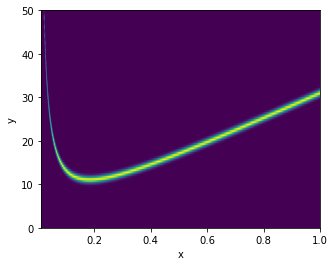

In [3]:
x_grid = torch.linspace(0.01, 1, 1000)
y_grid = torch.linspace(0, 50, 100)

all_likelihoods = []
for y_ in y_grid:
    y_o = y_
    likelihoods = torch.exp(log_likelihood(x_grid))
    all_likelihoods.append(likelihoods)
all_likelihoods = torch.stack(all_likelihoods)

fig, ax = plt.subplots(1, 1, figsize=(5, 4))
plt.imshow(all_likelihoods.numpy(), origin="lower", extent=[0.01, 1, 0, 50], aspect="auto")
_ = ax.set_xlabel("x")
_ = ax.set_ylabel("y")

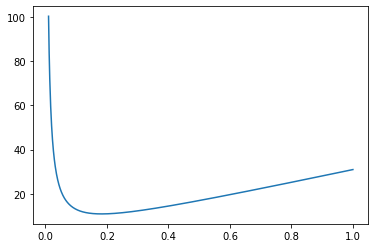

In [6]:
x = torch.linspace(0.01, 1, 1000)
plt.plot(x, 30*x + 1/x)

Assume the observed data is $y_o = 11.2$.

In [7]:
y_o = 11.2

Then, given likelihood and prior, we can compute the unnormalized posterior $p(x | y_o) \propto p(y_o | x)p(x)$. Implement such a function:

In [16]:
prior.log_prob(torch.tensor([0.6]))

tensor([0.0101])

In [21]:
def unnormalized_log_posterior(x):
    mean = 30*x + 1/x
    return noise_dist.log_prob(y_o - mean) + prior.log_prob(x)
# If implemented correctly, this should return:

assert torch.allclose(unnormalized_log_posterior(torch.tensor([0.5])), torch.tensor([-67.4958]))
assert torch.allclose(unnormalized_log_posterior(torch.tensor([0.6, 0.8])),
                     torch.tensor([-143.5846, -395.0208]))
# unnormalized_log_posterior(torch.tensor([0.5])) -> tensor([-67.4958])
# unnormalized_log_posterior(torch.tensor([0.6, 0.8])) -> tensor([-143.5846, -395.0208])

In [22]:
def unnormalized_posterior(x):
    return torch.exp(unnormalized_log_posterior(x))

### Establishing a ground truth

In this simple model, we can even compute the normalization constant by numerical integration (on a grid). We will use this to obtain a ground truth for the posterior later on. Note that, in more challenging real-world scenarios, this will not usually be possible. There are no tasks for you to do in this section, but please make sure that you understand the code.

In [23]:
dx = 0.99 / 999
l = unnormalized_posterior(x_grid)
Z_true = torch.sum(l) * dx

After having estimated the normalization constant, we can write a function that allows us to evaluate the posterior:

In [24]:
def posterior(x):
    return unnormalized_posterior(x) / Z_true

Let's visualize this:

In [25]:
x_grid = torch.linspace(0.01, 1, 1000)
posterior_values_on_grid = posterior(x_grid)

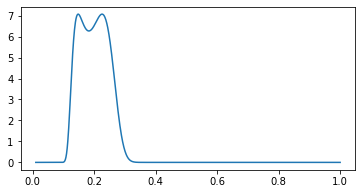

In [26]:
fig, ax = plt.subplots(1, 1, figsize=(6,3))
_ = ax.plot(x, posterior_values_on_grid.detach().numpy())

In order to get a ground-truth value for the posterior mean, we compute the expected value of this posterior:

In [27]:
func_val = x_grid * posterior(x_grid)
mean_true = torch.sum(func_val) * dx
print("Mean when integrating on grid: ", mean_true.detach().item())

Mean when integrating on grid:  0.19864846765995026


### Laplace approximation

In almost any real-world scenario, we can not compute the normalization constant of the posterior and we, therefore, can not evaluate the posterior mean as done above. Instead, we have to rely on other methods to approximate the posterior or generate (approximate) samples from it.

We will now explore a laplace-approximation to the posterior. Write a function to obtain the Maximum-likelihood-estimate $x_{\text{MLE}} = \min_{x} -\log p(x | y)$ with gradient descent. As starting point, use $x = 0.99$.

In [33]:
x_mle

tensor([0.9900], requires_grad=True)

In [37]:
x_mle

tensor([-21.6259], requires_grad=True)

In [74]:
x_mle = torch.tensor([0.99], requires_grad=True)
optim = torch.optim.SGD([x_mle], lr=0.0004)
# optim = torch.optim.AdamW([x_mle], lr=0.05)

for _ in range(500):
        optim.zero_grad()
        loss = -unnormalized_log_posterior(x_mle)
        # print(loss)
        loss.backward()
        optim.step()
        
# If implemented correctly, the x_mle should be
# Parameter containing:
# tensor([0.2270], requires_grad=True)
print(x_mle)

tensor([0.2255], requires_grad=True)


Compute the hessian of the unnormalized log-posterior around the maximum likelihood estimate. Use the pytorch method `hessian`.

In [78]:
torch.autograd.functional.hessian(unnormalized_log_posterior, x_mle)

tensor([[-427.7725]])

In [80]:
H = torch.autograd.functional.hessian(unnormalized_log_posterior, x_mle)
# If implemented correctly, the hessian should be:
# tensor([[-458.7795]])
H

tensor([[-427.7725]])

...and construct the laplace approximation $\mathcal{N}(\mu=x_{\text{MLE}}, \sigma=\sqrt{-H^{-1}})$:

In [88]:
laplace_approximation = torch.distributions.Normal(x_mle[0], 1/torch.sqrt(-H[0][0]))
laplace_approximation

Normal(loc: 0.2255396693944931, scale: 0.04834967851638794)

We can again visualize this distribution and compare it to the (in this simple case available) ground truth posterior:

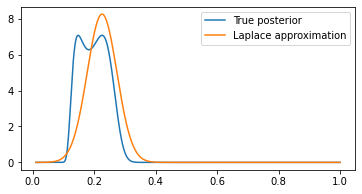

In [89]:
laplace_approximation_values_on_grid = torch.exp(laplace_approximation.log_prob(x_grid)).squeeze()

fig, ax = plt.subplots(1, 1, figsize=(6,3))
_ = ax.plot(x_grid, posterior_values_on_grid.detach().numpy())
_ = ax.plot(x_grid, laplace_approximation_values_on_grid.detach().numpy())
_ = ax.legend(["True posterior", "Laplace approximation"])

From the above plot, we can already guess that the mean of the laplace approximation will be higher than the true posterior mean. Since the Laplace approximation is a gaussian, it's mean is the maximum-likelihood estimate:

In [90]:
laplace_mean = laplace_approximation.mean
print("Mean as estimated by laplace: ", laplace_mean.detach().item())

Mean as estimated by laplace:  0.2255396693944931


### Refine with importance sampling

The laplace approximation **overestimated the posterior mean**. Let's see if we can fix this with importance sampling. **We will use the Laplace approximation as proposal distribution** $q(x)$. We then compute:

$\mathbb{E}[p(x | y)] = \int p(x | y) \; x \; dx = \int \frac{p(x | y)}{q(x)} \; x \; q(x) \; dx \approx \frac{1}{N} \sum_i \frac{p(x_i | y)}{q(x_i)} x_i$.

However, in the current scenario, the we can only estimate the posterior distribution **up to proportionality**. Therefore, we first have to estimate the normalization constant $Z$ of the unnormalized posterior $\tilde{p}(x | y)$. We again do so with importance sampling:

$Z = \int \tilde{p}(x | y) dx = \int \frac{\tilde{p}(x | y)}{q(x)} q(x) dx \approx \frac{1}{N} \sum_i \frac{\tilde{p}(x_i | y)}{q(x_i)}$. Let's first estimate $Z$:

In [91]:
laplace_approximation.sample(sample_shape=(100, ))

tensor([0.2941, 0.2801, 0.2195, 0.2042, 0.1938, 0.1881, 0.2084, 0.1838, 0.1581,
        0.2139, 0.1979, 0.1889, 0.2986, 0.2440, 0.2705, 0.2566, 0.1847, 0.2618,
        0.2280, 0.2191, 0.2433, 0.1756, 0.1771, 0.1282, 0.2407, 0.1776, 0.2357,
        0.1726, 0.2219, 0.2696, 0.2898, 0.2346, 0.1845, 0.2457, 0.2579, 0.2647,
        0.2893, 0.1733, 0.1959, 0.1654, 0.2476, 0.2511, 0.1553, 0.2709, 0.1521,
        0.2058, 0.2140, 0.2264, 0.2207, 0.2909, 0.2018, 0.2860, 0.1869, 0.2171,
        0.2526, 0.2462, 0.2165, 0.2487, 0.2033, 0.2121, 0.1778, 0.2543, 0.1339,
        0.2331, 0.1801, 0.2029, 0.1799, 0.2345, 0.3207, 0.2422, 0.2017, 0.1616,
        0.2232, 0.3073, 0.1520, 0.2522, 0.2424, 0.2724, 0.1974, 0.1857, 0.1542,
        0.2550, 0.1714, 0.1468, 0.1786, 0.2003, 0.1934, 0.1488, 0.1940, 0.1952,
        0.2186, 0.2538, 0.1772, 0.2125, 0.2687, 0.1346, 0.1731, 0.1911, 0.2198,
        0.2052])

In [94]:
laplace_samples = laplace_approximation.sample(sample_shape=(100, ))
laplace_log_probs = laplace_approximation.log_prob(laplace_samples)
laplace_probs = torch.exp(laplace_log_probs)

unnormalized_posterior_probs = unnormalized_posterior(laplace_samples)
Z = (unnormalized_posterior_probs/laplace_probs).mean() # Estimate Z with importance sampling.

# If implemented correctly, Z should be approximately: tensor(0.1154)
print(Z)

tensor(0.1088, grad_fn=<MeanBackward0>)


Then we can estimate the posterior mean with importance sampling:

In [101]:
importance_sampling_mean = (laplace_samples * (unnormalized_posterior_probs/Z) / laplace_probs).mean()
# Estimate the mean with importance sampling

In [102]:
print("mean as estimated by laplace + importance sampling: ", importance_sampling_mean.detach().item())

mean as estimated by laplace + importance sampling:  0.20074723660945892


This is a very good estimate of the true posterior mean. Congratualtions, you are done with the first part of the programming exercise!

# Gibbs sampling for the Ising model

The Ising model is a mathematical model of ferromagnetism in statistical mechanics. The model consists of discrete variables that represent magnetic dipole moments of atomic "spins" that can be in one of two states (+1 or −1). The spins are arranged in a lattice, allowing each spin to interact with its neighbors. Neighboring spins that agree have a lower energy than those that disagree; the system tends to the lowest energy but heat disturbs this tendency, thus creating the possibility of different structural phases. The image illustrates an ising model on a 2D-lattice:

<img src="ising_model.png" width="400" height="300">

[Image source](https://www.researchgate.net/figure/Schematic-representation-of-a-configuration-of-the-2D-Ising-model-on-a-square-lattice_fig2_321920877)

The probability of a particular state $\sigma$ (i.e., a set of spins) in this system is given by:

$p(\sigma) = \frac{\exp(-\beta H(\sigma))}{Z}$.

The normlization constant $Z$ is computationally expensive to evaluate. $H(\sigma)$ is the hamiltonian defined as:

$H(\sigma) = -\sum_{\langle i,j \rangle} J_{i,j}\sigma_i\sigma_j - \mu \sum_j h_j \sigma_j$

The notation $\langle i,j \rangle$ indicates that $i,j$ are neighbours. $J$ models the interactions between neighbours. We will assume that the magnetic moment $\mu$ is zero and that J is one:

$H(\sigma) = -\sum_{\langle i,j \rangle} \sigma_i\sigma_j$

This model (in a circular version, so last spin's right neighbour is the first spin) and a 1D-lattice is implemented below:

In [103]:
num_dim = 10

J = 1. # energy due to local field from nearby spins --> corresponds to diffusion term in Hamiltonian
h = 0. # energy due to external field --> corresponds to drift term in Hamiltonian

def hamiltonian(sigma):
#     Hamiltonian = H = -J * (Sum over pairs of nearest neighbour spins) - h (sum over spins).
#     Assume 1D lattice, so nearest neighbours are on the right and left of each spin.
#     Assume that lattice is circular, so last spin's right neighbour is the first spin.
    assert sigma.dim() == 1
    nn_left = torch.roll(sigma, -1) # roll lattice to get all left neighbours
    nn_right = torch.roll(sigma, 1) # roll lattice to get all right neighbours
    term1 = nn_left.dot(sigma)
    term2 = nn_right.dot(sigma)
    
    term3 = sigma.sum()
    return -J * (term1 + term2) - h * term3

In [104]:
def ising_prob(sigma, beta):
    return torch.exp(-beta * hamiltonian(sigma))

In this tutorial, we will investigate how one can sample states $\sigma$ given the unnormalized density function $\tilde{p}(\sigma) \propto \exp(-\beta H(\sigma))$. We will do so with Gibbs-sampling.

Each value of the initial state is sampled from a discrete distribution that has $p(1) = 0.5$ and $p(-1) = 0.5$.

In [105]:
initial = torch.as_tensor(torch.randint(2, (num_dim,)) * 2 - 1, dtype=torch.float32)

We then need a function that evaluates the conditional distribution $\tilde{p}(\sigma_i | \sigma_{j \neq i} = \overline{\sigma}_{j \neq i})$ given the current state $\overline{\sigma}$. To obtain this, first write functions that evaluate $\tilde{p}(\sigma_i = 1, \sigma_{j \neq i} = \overline{\sigma}_{j \neq i})$ and $\tilde{p}(\sigma_i = -1, \sigma_{j \neq i} = \overline{\sigma}_{j \neq i})$:

In [ ]:
def joint_dist_at_plus_1(sigma, dim, beta):
    ...
    return ...

def joint_dist_at_minus_1(sigma, dim, beta):
    ...
    return ...

# If implemented correctly, the results should be approximately:
# conditional_dist_at_plus_1(torch.ones(10), 0, 0.1) -> tensor(7.3891)
# conditional_dist_at_minus_1(torch.ones(10), 0, 0.1) -> tensor(3.3201)

Using these functions, write a function that evaluates $\tilde{p}(\sigma_i = 1 | \sigma_{j \neq i})$. Note that $\tilde{p}(\sigma_i = 1 | \sigma_{j \neq i}) \propto \tilde{p}(\sigma_i = 1, \sigma_{j \neq i})$, i.e., all you have to do is normalize the values of the above functions such that they sum to one.

In [2]:
def conditional_dist_at_plus_1(sigma, dim, beta):
    ...
    return ...

# If implemented correctly, the results should be approximately:
# conditional_dist_at_plus_1(torch.ones(10), 0, 0.1) -> tensor(0.6900)

Finally, write a function that uses `conditional_dist_at_plus_1` to sample the conditional distribution $\tilde{p}(\sigma_i | \sigma_{j \neq i})$ using `torch.distributions.Bernoulli`.

In [1]:
def sample_conditional(sigma, dim, beta):
    ...
    return conditional_samples # Should have shape (1,)

# E.g. sample_conditional(torch.ones(10), 1, 0.5) -> tensor([1.])

Finally, write a function that loops over every dimension and samples each conditional once:

In [ ]:
def gibbs(sigma, beta):
    ...
    return ...

Done! We have implemented the Gibbs-sampler for the Ising model. We can now simulate the Ising model for different values of $\beta$. We will start with low temperatures, i.e., high values of $\beta$.

In [ ]:
beta = 0.5

Run the gibbs sampler for $N$ steps. Visualize the states as an $[N, D]$ matrix, with $D$ being the number of states of the system:

In [ ]:
all_samples = []
for _ in range(20):
    s = gibbs(initial, beta=beta)
    all_samples.append(deepcopy(s))
all_samples = torch.stack(all_samples)

fig, ax = plt.subplots(1, 1, figsize=(6, 4))
_ = ax.imshow(all_samples.numpy())
ax.set_xlabel("State")
ax.set_ylabel("Gibbs iteration")

We can check whether samples returned by the gibbs sampler indeed produce states that have high probability. Compute the average probability of states sampled by the Gibbs sampler and compare them to sampling states independently and uniformly.

In [ ]:
average_prob_gibbs = torch.mean(torch.stack([ising_prob(s, beta=beta) for s in all_samples]))
print("Average (unnormalized) probability of gibbs samples:", average_prob_gibbs)

In [ ]:
random_samples = torch.as_tensor(torch.randint(2, (50, num_dim)) * 2 - 1, dtype=torch.float32)
average_prob_random = torch.mean(torch.stack([ising_prob(s, beta=beta) for s in random_samples]))
print("Average (unnormalized) probability of random samples:", average_prob_random)

Next, we will run the sampler for high temperatures:

In [ ]:
beta = 0.001

In [ ]:
all_samples = []
for _ in range(20):
    s = gibbs(initial, beta=beta)
    all_samples.append(deepcopy(s))
all_samples = torch.stack(all_samples)

fig, ax = plt.subplots(1, 1, figsize=(6, 4))
_ = ax.imshow(all_samples.numpy())
_ = ax.set_xlabel("State")
_ = ax.set_ylabel("Gibbs iteration")